In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from pathlib import Path

In [25]:
path = Path('/fastdata/contrails')
files = list(path.glob('*'))
files

[PosixPath('/fastdata/contrails/fold_7_val.csv'),
 PosixPath('/fastdata/contrails/train'),
 PosixPath('/fastdata/contrails/sample_submission.csv'),
 PosixPath('/fastdata/contrails/fold_3_val.csv'),
 PosixPath('/fastdata/contrails/fold_5_val.csv'),
 PosixPath('/fastdata/contrails/fold_0_val.csv'),
 PosixPath('/fastdata/contrails/stats.csv'),
 PosixPath('/fastdata/contrails/fold_0.csv'),
 PosixPath('/fastdata/contrails/validation_metadata.json'),
 PosixPath('/fastdata/contrails/fold_8_val.csv'),
 PosixPath('/fastdata/contrails/fold_9_val.csv'),
 PosixPath('/fastdata/contrails/fold_9.csv'),
 PosixPath('/fastdata/contrails/fold_1.csv'),
 PosixPath('/fastdata/contrails/fold_4.csv'),
 PosixPath('/fastdata/contrails/fold_1_val.csv'),
 PosixPath('/fastdata/contrails/fold_5.csv'),
 PosixPath('/fastdata/contrails/fold_7.csv'),
 PosixPath('/fastdata/contrails/fold_3.csv'),
 PosixPath('/fastdata/contrails/fold_2.csv'),
 PosixPath('/fastdata/contrails/fold_6.csv'),
 PosixPath('/fastdata/contrails/f

In [26]:
import pandas as pd

train_metdata = pd.read_json(path/'train_metadata.json')
len(train_metdata)

20529

In [27]:
import os 

records = os.listdir(path / 'train')
len(records)

20529

In [28]:
files = list(path.glob(f'train/{records[0]}/*'))
files


[PosixPath('/fastdata/contrails/train/2175739284570639142/band_15.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_09.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_12.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_10.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/human_pixel_masks.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_14.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_16.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_13.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_08.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_11.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/human_individual_masks.npy')]

In [29]:
val_metadata = pd.read_json(path/'validation_metadata.json')
len(val_metadata)

1856

In [30]:
val_records = os.listdir(path / 'validation')
len(val_records)

1856

In [31]:
import numpy as np 

image = np.load('/fastdata/contrails/train/2175739284570639142/band_15.npy')
image.shape

(256, 256, 8)

In [32]:
image.min(), image.max(), image.dtype

(244.4923, 286.61728, dtype('float32'))

In [33]:
mask = np.load('/fastdata/contrails/train/2175739284570639142/human_pixel_masks.npy')
mask.shape

(256, 256, 1)

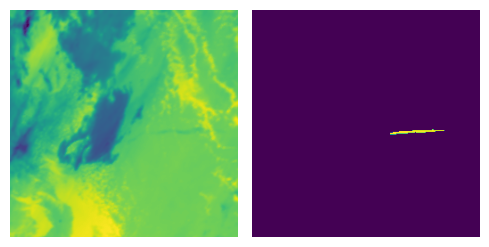

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 2, 1)
ax.imshow(image[...,4])
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(mask[...,0])
ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
def get_stats(args):
    record, band = args
    image = np.load(path / 'train' / record / f'band_{band:02d}.npy')
    return band, image.min(), image.max(), image.mean(), image.std()

In [14]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm

try:
	stats = pd.read_csv(path/'stats.csv', index_col=0)
except:
	num_cores = multiprocessing.cpu_count()
	bands = range(8,17)
	args = [(record, band) for record in records for band in bands]

	with ProcessPoolExecutor(max_workers=num_cores) as pool:
		with tqdm(total=len(args)) as progress:
			futures = []
			for arg in args:
				future = pool.submit(get_stats, arg) # enviamos la tupla de argumentos
				future.add_done_callback(lambda p: progress.update())
				futures.append(future)
			results = []
			for future in futures:
				result = future.result()
				results.append(result)

	stats = {b: {'min': [], 'max': [], 'mean': [], 'std': []} for b in bands}
	for band, min_, max_, mean_, std_ in results:
		stats[band]['min'].append(min_)
		stats[band]['max'].append(max_)
		stats[band]['mean'].append(mean_)
		stats[band]['std'].append(std_)

	final_stats = {
		b: {
			'min': np.min(stats[b]['min']), 
			'max': np.max(stats[b]['max']),
			'mean': np.mean(stats[b]['mean']),
			'std': np.mean(stats[b]['std'])
			} 
		for b in bands
	}

	df = pd.DataFrame(final_stats)
	df = df.T
	df.to_csv(path/'stats.csv')
	stats = pd.read_csv(path/'stats.csv', index_col=0)

stats

,min,max,mean,std
8,175.82391,280.14868,233.67686,4.545741
9,180.74695,279.48690,242.25447,6.057177
10,181.44263,331.13394,250.75069,7.620164
11,179.33739,332.06036,274.41205,13.668153
12,187.69131,306.21823,255.52716,8.708825
13,179.34510,338.05670,276.60184,14.446373
14,178.71164,338.63330,275.35940,14.736154
15,178.36511,333.21048,272.56410,14.367307
16,137.39153,311.97977,260.42580,11.049050


In [15]:
import pandas as pd 

sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission

,record_id,encoded_pixels
0,1000834164244036115,1 3 10 5
1,1002653297254493116,-


In [18]:
from src.ds import Dataset

# all bands, full sequence, mean/std norm

ds = Dataset()

In [19]:
image, mask = ds[0]

image.shape, image.dtype, image.max(), image.min(), mask.shape, mask.dtype, mask.max(), mask.min()

AttributeError: 'NoneType' object has no attribute 'loc'

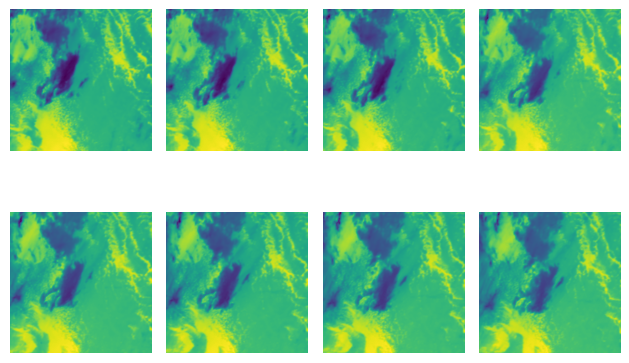

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
rows, cols = 2, 4
for i in range(rows*cols):
	ax = plt.subplot(rows, cols, i+1)
	ax.imshow(image[...,i,3])
	ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# some bands, some sequence, min/max norm

ds = Dataset(bands=[12,13,14], t=[0,1,2,3], norm_mode='min_max')

In [ ]:
image, mask = ds[0]

image.shape, image.dtype, image.max(), image.min(), mask.shape, mask.dtype, mask.max(), mask.min()

(torch.Size([256, 256, 4, 3]),
 torch.float32,
 tensor(0.6942),
 tensor(0.4182),
 torch.Size([256, 256]),
 torch.int32,
 tensor(1, dtype=torch.int32),
 tensor(0, dtype=torch.int32))

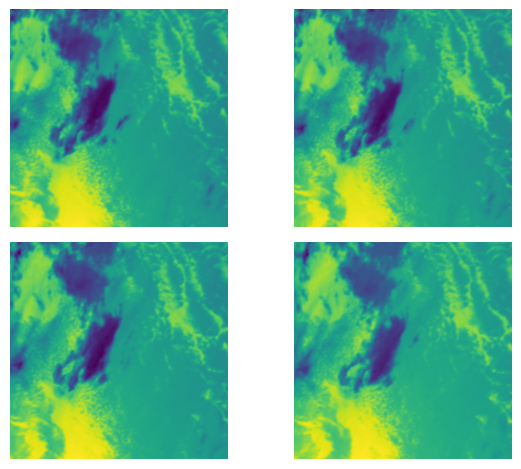

In [ ]:
fig = plt.figure()
rows, cols = 2, 2
for i in range(rows*cols):
	ax = plt.subplot(rows, cols, i+1)
	ax.imshow(image[...,i,0])
	ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# one band, one t

ds = Dataset(bands=[12], t=[4], norm_mode='min_max')

In [ ]:
image, mask = ds[0]

image.shape, image.dtype, image.max(), image.min(), mask.shape, mask.dtype, mask.max(), mask.min()

(torch.Size([256, 256, 1, 1]),
 torch.float32,
 tensor(0.5868),
 tensor(0.4167),
 torch.Size([256, 256]),
 torch.int32,
 tensor(1, dtype=torch.int32),
 tensor(0, dtype=torch.int32))

In [20]:
# false color

ds = Dataset(false_color=True, t=[0,1,2,3])

In [21]:
image, mask = ds[0]

image.shape, image.dtype, image.max(), image.min(), mask.shape, mask.dtype, mask.max(), mask.min()

(torch.Size([256, 256, 4, 3]),
 torch.float32,
 tensor(0.9378),
 tensor(0.),
 torch.Size([256, 256]),
 torch.int32,
 tensor(0, dtype=torch.int32),
 tensor(0, dtype=torch.int32))

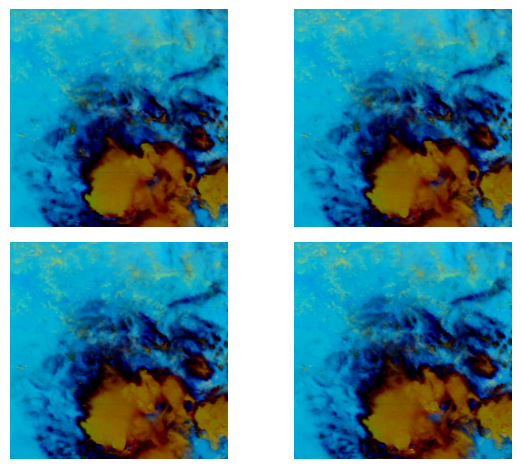

In [22]:
fig = plt.figure()
rows, cols = 2, 2
for i in range(rows*cols):
	ax = plt.subplot(rows, cols, i+1)
	ax.imshow(image[...,i,:])
	ax.axis('off')
plt.tight_layout()
plt.show()

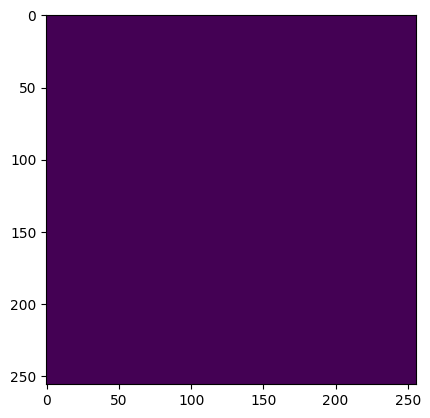

In [23]:
plt.imshow(mask)
plt.show()